In [ ]:
!pip install gym==0.26.2
!pip install pygame

import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=03042c1ee63880d57abbc7fe5f7aa4e717486519b5d201058232b23e42921c48
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)

In [ ]:
def value_iteration(env, gamma=0.99, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            Q_sa = []
            for a in range(env.action_space.n):
                q = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    q += prob * (reward + gamma * V[next_state])
                Q_sa.append(q)
            V[s] = max(Q_sa)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [ ]:
def epsilon_greedy(Q, state, epsilon, n_actions):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

In [ ]:
def create_epsilon_scheduler(eps_start=0.75, eps_end=0.001, total_episodes=8000, decay_portion=0.3):
    decay_episodes = int(decay_portion * total_episodes)
    def scheduler(ep):
        if ep < decay_episodes:
            return eps_start - (ep / decay_episodes) * (eps_start - eps_end)
        return eps_end
    return scheduler

In [ ]:
def train_q_learning(env, alpha, gamma, epsilon_scheduler, V_star, episodes=8000):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rmse_list = []

    for ep in range(episodes):
        state = env.reset()[0]
        done = False
        epsilon = epsilon_scheduler(ep)

        while not done:
            action = epsilon_greedy(Q, state, epsilon, n_actions)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state, best_next_action]
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state

        V_estimated = np.max(Q, axis=1)
        rmse = np.sqrt(np.mean((V_star - V_estimated) ** 2))
        rmse_list.append(rmse)

    return rmse_list

In [ ]:
def train_sarsa(env, alpha, gamma, epsilon_scheduler, V_star, episodes=8000):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rmse_list = []

    for ep in range(episodes):
        state = env.reset()[0]
        epsilon = epsilon_scheduler(ep)
        action = epsilon_greedy(Q, state, epsilon, n_actions)

        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                td_target = reward + gamma * Q[next_state, next_action]
            else:
                td_target = reward

            Q[state, action] += alpha * (td_target - Q[state, action])
            state = next_state
            action = next_action if not done else None

        V_estimated = np.max(Q, axis=1)
        rmse = np.sqrt(np.mean((V_star - V_estimated) ** 2))
        rmse_list.append(rmse)

    return rmse_list

In [ ]:
def train_n_step_sarsa(env, alpha, gamma, epsilon_scheduler, V_star, n=3, episodes=8000):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rmse_list = []

    for ep in range(episodes):
        epsilon = epsilon_scheduler(ep)
        state = env.reset()[0]
        action = epsilon_greedy(Q, state, epsilon, n_actions)

        states = [state]
        actions = [action]
        rewards = [0]
        T = float('inf')
        t = 0
        tau = -1
        done = False

        while True:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(actions[t])
                done = terminated or truncated
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                    actions.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                G = 0.0
                for i in range(tau + 1, min(tau + n + 1, T + 1)):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                if tau + n < T:
                    G += (gamma ** n) * Q[states[tau + n], actions[tau + n]]

                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            if tau == T - 1:
                break

            t += 1

        V_estimated = np.max(Q, axis=1)
        rmse = np.sqrt(np.mean((V_star - V_estimated) ** 2))
        rmse_list.append(rmse)

    return rmse_list

In [ ]:
!pip install numpy==1.23.5 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have nu

In [ ]:
alpha_values = [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
repetitions = 20
episodes = 8000

gamma = 0.99

V_star = value_iteration(env, gamma=gamma)

rmse_results = {
    'Q-Learning': [],
    'SARSA': [],
    'n=2': [],
    'n=3': [],
    'n=4': []
}

for alpha in alpha_values:
    print(f"Alpha = {alpha}")
    rmse_q, rmse_sarsa, rmse_n2, rmse_n3, rmse_n4 = [], [], [], [], []

    for rep in range(repetitions):
        eps_scheduler = create_epsilon_scheduler()

        rmse_q.append(train_q_learning(env, alpha, gamma, eps_scheduler, V_star)[-1])
        rmse_sarsa.append(train_sarsa(env, alpha, gamma, eps_scheduler, V_star)[-1])
        rmse_n2.append(train_n_step_sarsa(env, alpha, gamma, eps_scheduler, V_star, n=2)[-1])
        rmse_n3.append(train_n_step_sarsa(env, alpha, gamma, eps_scheduler, V_star, n=3)[-1])
        rmse_n4.append(train_n_step_sarsa(env, alpha, gamma, eps_scheduler, V_star, n=4)[-1])

    rmse_results['Q-Learning'].append(np.mean(rmse_q))
    rmse_results['SARSA'].append(np.mean(rmse_sarsa))
    rmse_results['n=2'].append(np.mean(rmse_n2))
    rmse_results['n=3'].append(np.mean(rmse_n3))
    rmse_results['n=4'].append(np.mean(rmse_n4))

Alpha = 0.0
Alpha = 0.1
Alpha = 0.3
Alpha = 0.5
Alpha = 0.7
Alpha = 1.0


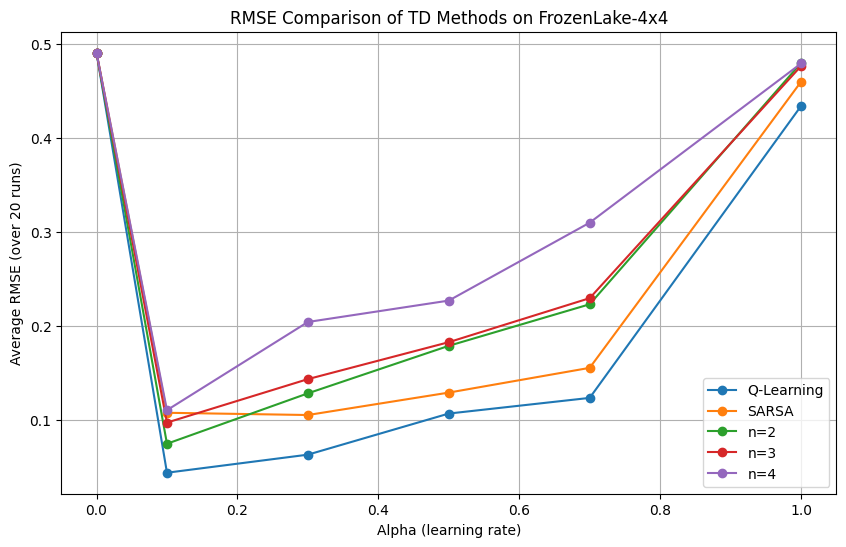

In [ ]:
plt.figure(figsize=(10, 6))
for label, values in rmse_results.items():
    plt.plot(alpha_values, values, marker='o', label=label)

plt.xlabel("Alpha (learning rate)")
plt.ylabel("Average RMSE (over 20 runs)")
plt.title("RMSE Comparison of TD Methods on FrozenLake-4x4")
plt.grid(True)
plt.legend()
plt.show()